# Coursework1: Convolutional Neural Networks 

## instructions

Please submit a version of this notebook containing your answers **together with your trained model** on CATe as CW2.zip. Write your answers in the cells below each question.

### Setting up working environment 

For this coursework you will need to train a large network, therefore we recommend you work with Google Colaboratory, which provides free GPU time. You will need a Google account to do so. 

Please log in to your account and go to the following page: https://colab.research.google.com. Then upload this notebook.

For GPU support, go to "Edit" -> "Notebook Settings", and select "Hardware accelerator" as "GPU".

You will need to install pytorch by running the following cell:

In [17]:
!pip install torch torchvision

## Introduction

For this coursework you will implement one of the most commonly used model for image recognition tasks, the Residual Network. The architecture is introduced in 2015 by Kaiming He, et al. in the paper ["Deep residual learning for image recognition"](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf). 
<br>

In a residual network, each block contains some convolutional layers, plus "skip" connections, which allow the activations to by pass a layer, and then be summed up with the activations of the skipped layer. The image below illustrates a building block in residual networks.

![resnet-block](utils/resnet-block.png)

Depending on the number of building blocks, resnets can have different architectures, for example ResNet-50, ResNet-101 and etc. Here you are required to build ResNet-18 to perform classification on the CIFAR-10 dataset, therefore your network will have the following architecture:

![resnet](utils/resnet.png)

## Part 1 (40 points)

In this part, you will use basic pytorch operations to define the 2D convolution, max pooling operation, linear layer as well as 2d batch normalization. 

### YOUR TASK

- implement the forward pass for Conv2D, MaxPool2D, Linear and BatchNorm2d
- You are **NOT** allowed to use the torch.nn modules

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [19]:
################################################################################
#                                IMPORTANT                                     #
################################################################################


# OPTIMISE AND VISUALISE 
# Setting this boolean to True will allow autograd when using ResNet with my 
# overloaded functions. To do this the "from torch.nn import Conv2d, MaxPool2d" 
# must be removed and BatchNorm and Linear layers must be included without "nn."
# Having this on runs code that defines learnable parameters as nn.Parameters, 
# while having it off all it is needed is simple tensors.
# This parameter will also trigger visualisation code in Part 2! Setting this on
# True will run confusion matrix plot and mean metrics calculation by including 
# some changes in the pre-defined functions "train_part" and "check_accuracy".
# Having it Off will simply disregard visualisation.

OPTIMISE_AND_VISUALISE = False
SAVING_ON_DRIVE = False

# GOOGLE DRIVE #
if SAVING_ON_DRIVE:
    from google.colab import drive
    drive.mount('/content/gdrive')

################################################################################

In [20]:
class Conv2d(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 padding=0,
                 bias=True):

        super(Conv2d, self).__init__()
        """
        An implementation of a convolutional layer.

        The input consists of N data points, each with C channels, height H and
        width W. We convolve each input with F different filters, where each filter
        spans all C channels and has height HH and width WW.

        Parameters:
        - w: Filter weights of shape (F, C, HH, WW)
        - b: Biases, of shape (F,)
        - kernel_size: Size of the convolving kernel
        - stride: The number of pixels between adjacent receptive fields in the
            horizontal and vertical directions.
        - padding: The number of pixels that will be used to zero-pad the input.
        """

        ########################################################################
        # TODO: Define the parameters used in the forward pass                 #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


        ######## HARDWARE OPTIMISATION ########################
        if torch.cuda.is_available():
            device = torch.device('cuda:0')
        else:
            device = torch.device('cpu')


        ######## MEMBER VARIABLES DEFINITIONS #################
        self.in_channels  = in_channels
        self.out_channels = out_channels

        # Initialise self.kernel_size, stride and padding to tuples.
        self.kernel_size = kernel_size if type(kernel_size) is tuple else (kernel_size, kernel_size)
        self.stride =  stride if type(stride) is tuple else (stride,stride)
        self.padding = padding if type(padding) is tuple else (padding, padding)

        ########### LEARNABLE PARAMETERS #####################       
        # Initialise k following the Pytorch definition.
        k = 1 / np.sqrt(self.kernel_size[0] * self.kernel_size[1] * 
                        self.in_channels)

        # Initialising uniform random weights and bias.
        if OPTIMISE_AND_VISUALISE: 
            self.w = nn.Parameter(
                        torch.Tensor(
                            torch.zeros(
                                  (self.out_channels,
                                  self.in_channels,
                                  self.kernel_size[0],
                                  self.kernel_size[1])
                            )
                        ).uniform_(-k, k).to(device=device)
                     )
            self.b = nn.Parameter(
                        torch.Tensor(
                            torch.zeros((self.out_channels, ))
                        ).requires_grad_(True).uniform_(-k, k).to(device=device) 
                     ) if bias else None
            
        else: 
            with torch.no_grad():
                self.w = nn.Parameter(
                            torch.Tensor(
                                torch.zeros(
                                      (self.out_channels,
                                      self.in_channels,
                                      self.kernel_size[0],
                                      self.kernel_size[1])
                                )
                            ).requires_grad_(True).uniform_(-k, k).to(device=device)
                        )
                # Initialise random bias if bias flag is set. 
                self.b = torch.Tensor(
                            torch.zeros((self.out_channels, ))
                         ).requires_grad_(True).uniform_(-k, k).to(device=device) if bias else None
                     


        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data, of shape (N, F, H', W').
        """

        ########################################################################
        # TODO: Implement the forward pass                                     #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # Retrieve x.shape parameters into appropriate variables.
        batch_size, _, img_width, img_height = x.shape

        # Convoluted picture width and height
        conv_width  = int(
                          (img_width + 2 * self.padding[0] - (self.kernel_size[0] - 1) - 1) / self.stride[0] + 1
                      )
        conv_height = int(
                          (img_height + 2 * self.padding[1] - (self.kernel_size[1] - 1) - 1) / self.stride[1] + 1
                      )
        # Unfolding and folding operations allow efficient convolution.
        unf_x   = F.unfold(x, self.kernel_size, dilation=1, 
                           padding=self.padding, stride=self.stride).transpose(1,2)
        

        unf_out = unf_x.matmul(self.w.view(self.out_channels, -1).transpose(0,1))
        out = unf_out.transpose(1,2).view(batch_size, self.out_channels, conv_width, conv_height)

        #Add the bias if it is not None.
        if self.b is not None:
            out += self.b.view(1, self.out_channels, 1, 1)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################
        return out

In [21]:
class MaxPool2d(nn.Module):
    def __init__(self, kernel_size):
        super(MaxPool2d, self).__init__()
        """
        An implementation of a max-pooling layer.

        Parameters:
        - kernel_size: the size of the window to take a max over
        """
        ########################################################################
        # TODO: Define the parameters used in the forward pass                 #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # Initialise self.kernel_size and stride to the same tuple.
        self.kernel_size = kernel_size if type(kernel_size) is tuple else (kernel_size, kernel_size)
        self.stride =  self.kernel_size

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data, of shape (N, F, H', W').
        """
        ########################################################################
        # TODO: Implement the forward pass                                     #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # Retrieve x.shape parameters into appropriate variables.
        batch, channels, img_width, img_height = x.shape
        
        # Calculate expected output picture width and height
        exp_height = int((img_height - (self.kernel_size[0])) / self.stride[0]) + 1
        exp_width  = int((img_width - (self.kernel_size[1])) / self.stride[1]) + 1
        
        # Unfolding and folding operations allow efficient pooling.
        unf_x = F.unfold(
                    x, self.kernel_size, stride=self.stride
                ).transpose(2,1).view(
                    batch, -1, channels, self.kernel_size[0] * self.kernel_size[1]
                ).transpose(2,1)

        pool_out, _ = torch.max(unf_x, 3)
        out = F.fold(pool_out, output_size=(exp_width,exp_height) , kernel_size=1)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################
        return out

In [22]:
class Linear(nn.Module):
    def __init__(self, in_channels, out_channels, bias=True):
        super(Linear, self).__init__()
        """
        An implementation of a Linear layer.

        Parameters:
        - weight: the learnable weights of the module of shape (in_channels, out_channels).
        - bias: the learnable bias of the module of shape (out_channels).
        """
        ########################################################################
        # TODO: Define the parameters used in the forward pass                 #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        ######## HARDWARE OPTIMISATION ########################
        if torch.cuda.is_available():
            device = torch.device('cuda:0')
        else:
            device = torch.device('cpu')
        
        ######## MEMBER VARIABLES DEFINITIONS #################
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        ########### LEARNABLE PARAMETERS #####################       
        # Initialise k following the Pytorch definition.
        k = np.sqrt(1 / self.in_channels)

        # initialising random weights and bias.
        if OPTIMISE_AND_VISUALISE:
            self.weight = nn.Parameter(
                              torch.Tensor(
                                  self.in_channels, self.out_channels
                              ).uniform_(-k, k).to(device=device)
                          )
            self.bias = nn.Parameter(
                            torch.Tensor(
                                (self.out_channels, ),
                            ).uniform_(-k, k).to(device=device) 
                        ) if bias else None

        else: 
            with torch.no_grad():
                self.weight = torch.Tensor(
                                  self.in_channels, self.out_channels
                              ).requires_grad_(True).uniform_(-k, k).to(device=device)
                        
                self.bias = torch.Tensor(
                                (self.out_channels, ),
                            ).requires_grad_(True).uniform_(-k, k).to(device=device) if bias else None
                        

        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, *, H) where * means any number of additional
        dimensions and H = in_channels
        Output:
        - out: Output data of shape (N, *, H') where * means any number of additional
        dimensions and H' = out_channels
        """
        ########################################################################
        # TODO: Implement the forward pass                                     #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # Perform matrix multiplication between weights and input.
        out = torch.matmul(x, self.weight)

        # Adding bias if any.
        if self.bias is not None:
          out += self.bias

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

        return out

In [23]:
class BatchNorm2d(nn.Module):
    def __init__(self, num_features, eps=1e-05, momentum=0.1):
        super(BatchNorm2d, self).__init__()
        """
        An implementation of a Batch Normalization over a mini-batch of 2D inputs.

        The mean and standard-deviation are calculated per-dimension over the
        mini-batches and gamma and beta are learnable parameter vectors of
        size num_features.

        Parameters:
        - num_features: C from an expected input of size (N, C, H, W).
        - eps: a value added to the denominator for numerical stability. Default: 1e-5
        - momentum: momentum – the value used for the running_mean and running_var
        computation. Default: 0.1
        - gamma: the learnable weights of shape (num_features).
        - beta: the learnable bias of the module of shape (num_features).
        """
        ########################################################################
        # TODO: Define the parameters used in the forward pass                 #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        ######## HARDWARE OPTIMISATION ########################
        if torch.cuda.is_available():
            device = torch.device('cuda:0')
        else:
            device = torch.device('cpu')

        ######## MEMBER VARIABLES DEFINITIONS #################
        self.num_features = num_features 
        self.eps = eps
        self.momentum = 0 if momentum is None else momentum

        ########### LEARNABLE PARAMETERS #####################  
        # Gamma must be initialised to 4D tensors with channel size equal to the 
        # number of features and all other sizes equal to one. Gamma must be
        # filled with 1s, Beta with 0s.
        
        if OPTIMISE_AND_VISUALISE:
            self.gamma = nn.Parameter(
                            torch.Tensor(
                                torch.ones(size=(1, self.num_features, 1, 1))
                            ).to(device=device)
                        )
            self.beta = nn.Parameter(
                            torch.Tensor(
                                torch.zeros(size=(1, self.num_features, 1, 1))
                            )
                        ).to(device=device)             
        else: 
            with torch.no_grad():
                self.gamma = torch.Tensor(
                                torch.ones(size=(1, self.num_features, 1, 1), requires_grad=True)
                             ).to(device=device)
                self.beta = torch.Tensor(
                                torch.zeros(size=(1, self.num_features, 1, 1), requires_grad=True)
                            ).to(device=device)
        
        
        # Running mean and variance
        self.run_mean = torch.Tensor(
                            torch.zeros(
                                size=(1,self.num_features,1,1),
                                requires_grad=False
                            )                       
                        ).to(device=device)
        self.run_var = torch.Tensor(
                            torch.zeros(
                                size=(1,self.num_features,1,1),
                                requires_grad=False
                            )
                        ).to(device=device)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def forward(self, x):
        """
        During training this layer keeps running estimates of its computed mean and
        variance, which are then used for normalization during evaluation.
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data of shape (N, C, H, W) (same shape as input)
        """
        ########################################################################
        # TODO: Implement the forward pass                                     #
        #       (be aware of the difference for training and testing)          #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
        # Retrieve x.shape parameters into appropriate variables.
        batch_size, num_channels, _, _ = x.shape
        fold_dims = [0,2,3]
        
        # Batch Norm is a layer that behaves differently wether if it is training
        # or testing. When training, iterate cross batch to compute running mean
        # and variance, when testing use the running mean and variance to normalise.
        if self.training:
            self.mean = torch.mean(x, dim=fold_dims).view(1, num_channels, 1, 1)
            self.var  = torch.var(x, dim=fold_dims, unbiased=True).view(1, num_channels, 1, 1)

            # Running statistics must be performed without gradient.
            with torch.no_grad():
                self.run_mean = self.momentum * self.mean + (1 - self.momentum) * self.run_mean
                self.run_var  = self.momentum * self.var + (1 - self.momentum) * self.run_var
            
            # Define normalisation transform.
            data_norm = T.Normalize(self.mean, torch.sqrt(self.var + self.eps))
            # Use the transform to normalise x.
            normed_x = data_norm(x)
            # Compute output and store it into normed_x.
            normed_x = normed_x * self.gamma + self.beta 
   
        else: 
            # Define normalisation transform
            data_norm = T.Normalize(self.run_mean, torch.sqrt(self.run_var + self.eps))
            # Use the transform to normalise x.
            normed_x = data_norm(x)
            
            # No gradient.
            with torch.no_grad():
              # Compute output and store it into normed_x
              normed_x = normed_x * self.gamma + self.beta

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

        return normed_x

## Part 2

In this part, you will train a ResNet-18 defined on the CIFAR-10 dataset. Code for training and evaluation are provided. 

### Your Task

1. Train your network to achieve the best possible test set accuracy after a maximum of 10 epochs of training.

2. You can use techniques such as optimal hyper-parameter searching, data pre-processing

3. If necessary, you can also use another optimizer

4. **Answer the following question:**
Given such a network with a large number of trainable parameters, and a training set of a large number of data, what do you think is the best strategy for hyperparameter searching? 

In [24]:
import torch
from torch.nn import Conv2d, MaxPool2d
import torch.nn as nn
import torch.nn.functional as F

Next, we define ResNet-18:

In [25]:
# define resnet building blocks
# Dropout Layer Probability.
drop_prob = 0.08

class ResidualBlock(nn.Module): 
    def __init__(self, inchannel, outchannel, stride=1): 
        
        super(ResidualBlock, self).__init__() 
        
        self.left = nn.Sequential(Conv2d(inchannel, outchannel, kernel_size=3, 
                                         stride=stride, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel), 
                                  nn.Dropout(p=drop_prob),
                                  nn.ReLU(inplace=True), 
                                  Conv2d(outchannel, outchannel, kernel_size=3, 
                                         stride=1, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel),
                                  nn.Dropout(p=drop_prob)
                                  ) 
                                   
        
        self.shortcut = nn.Sequential() 
        
        if stride != 1 or inchannel != outchannel: 
            
            self.shortcut = nn.Sequential(Conv2d(inchannel, outchannel, 
                                                 kernel_size=1, stride=stride, 
                                                 padding = 0, bias=False), 
                                          nn.Dropout(p=drop_prob),
                                          nn.BatchNorm2d(outchannel),
                                          nn.Dropout(p=drop_prob)
                                          ) 
                                        
            
    def forward(self, x): 
        
        out = self.left(x) 
        
        out += self.shortcut(x) 
        
        out = F.relu(out) 
        
        return out


    
    # define resnet

class ResNet(nn.Module):
    
    def __init__(self, ResidualBlock, num_classes = 10):
        
        super(ResNet, self).__init__()
        
        self.inchannel = 64
        self.conv1 = nn.Sequential(Conv2d(3, 64, kernel_size = 3, stride = 1,
                                            padding = 1, bias = False), 
                                  nn.BatchNorm2d(64), 
                                  nn.ReLU(),
                                  nn.Dropout(p=drop_prob)
                                  )
        
        self.layer1 = self.make_layer(ResidualBlock, 64, 2, stride = 1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride = 2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride = 2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride = 2)
        self.maxpool = MaxPool2d(4)
        #self.fc = nn.Linear(512, num_classes)
        self.fc = Linear(512, num_classes)
        
    
    def make_layer(self, block, channels, num_blocks, stride):
        
        strides = [stride] + [1] * (num_blocks - 1)
        
        layers = []
        
        for stride in strides:
            
            layers.append(block(self.inchannel, channels, stride))
            
            self.inchannel = channels
            
        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        
        x = self.conv1(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.maxpool(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.fc(x)
        
        return x
    
    
def ResNet18():
    return ResNet(ResidualBlock)

### Loading dataset
We will import images from the [torchvision.datasets](https://pytorch.org/docs/stable/torchvision/datasets.html) library <br>
First, we need to define the alterations (transforms) we want to perform to our images - given that transformations are applied when importing the data. <br>
Define the following transforms using the torchvision.datasets library -- you can read the transforms documentation [here](https://pytorch.org/docs/stable/torchvision/transforms.html): <br>
1. Convert images to tensor
2. Normalize mean and std of images with values:mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]

In [26]:
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset

import numpy as np

import torchvision.transforms as T

##############################################################
#                       YOUR CODE HERE                       #       
##############################################################

simple_transform = T.Compose([T.ToTensor(),
                       T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])



data_transforms = {
    'train': T.Compose([
        T.RandomPerspective(distortion_scale=0.25, p=0.4, interpolation=3),
        T.RandomRotation(5),
        T.RandomAffine(0, translate=(0, 0.05)),
        T.RandomHorizontalFlip(p=0.5),
        T.ToTensor(),
        T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ]),
    'val': T.Compose([
        T.ToTensor(),
        T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ]),
    'test': T.Compose([
        T.ToTensor(),
        T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ]),
}
##############################################################
#                       END OF YOUR CODE                     #
##############################################################




Now load the dataset using the transform you defined above, with batch_size = 64<br>
You can check the documentation [here](https://pytorch.org/docs/stable/torchvision/datasets.html).
Then create data loaders (using DataLoader from torch.utils.data) for the training and test set

In [27]:

##############################################################
#                       YOUR CODE HERE                       #       
##############################################################


# Parameters.
data_dir = './data'
train_samples = 49000
tot_train_samples = 50000
batch = 64

cifar10_train = dset.CIFAR10(root='./data', train=True, download=True, 
                             transform=data_transforms['train'])
# validation set size is 2% of total observations.
cifar10_val = dset.CIFAR10(root='./data', train=True, download=True, 
                           transform=data_transforms['val'])

cifar10_test = dset.CIFAR10(root='./data', train=False, download=True, 
                            transform=data_transforms['test'])

loader_train = DataLoader(
                  cifar10_train, 
                  batch_size=batch, 
                  sampler=sampler.SubsetRandomSampler(range(train_samples))
               )
loader_val = DataLoader(
                cifar10_val, 
                batch_size=batch,
                sampler=sampler.SubsetRandomSampler(range(train_samples, tot_train_samples))
            )
loader_test = DataLoader(cifar10_test, batch_size=batch, shuffle=True)

##############################################################
#                       END OF YOUR CODE                     #       
##############################################################



Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [28]:
USE_GPU = True
dtype = torch.float32 

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using GPU")
else:
    device = torch.device('cpu')
    
    

print_every = 100
def check_accuracy(loader, model):
    # function for test accuracy on validation and test set
    
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0

    ########### ADDED ########################
    if OPTIMISE_AND_VISUALISE:
        all_preds = torch.tensor([], device=device)
        all_targets = torch.tensor([], device=device) 
    ##########################################

    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            
            ######## ADDED #################
            if OPTIMISE_AND_VISUALISE:
                if not loader.dataset.train:
                    all_preds = torch.cat(
                        (all_preds, preds),
                        dim=0
                    ) 
                    all_targets = torch.cat(
                        (all_targets, y),
                        dim=0
                    ) 
            #################################    
            
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    
    ######## ADDED #################
    if OPTIMISE_AND_VISUALISE:
        return all_preds, all_targets, 100 * acc 
    #################################

        

def train_part(model, optimizer, epochs=1, scheduler1=None, scheduler2=None):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    
    
    ########## ADDED #################
    if OPTIMISE_AND_VISUALISE:
        acc_curve = []
        loss_curve = []
    ##################################
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            loss.backward()

            # Update the parameters of the model using the gradients
            optimizer.step()
            
            if t % print_every == 0:
                print('Epoch: %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))

                ########## ADDED #################
                if OPTIMISE_AND_VISUALISE:
                    _, _, acc = check_accuracy(loader_val, model)
                    acc_curve.append(acc)
                    loss_curve.append(loss.item())
                else:
                ##################################
                    check_accuracy(loader_val, model)  
                print()


        if scheduler1 is not None:
            scheduler1.step()

        if scheduler2 is not None:
            scheduler2.step()
    
    ########## ADDED #################    
    if OPTIMISE_AND_VISUALISE:
        return acc_curve, loss_curve
    ##################################


Using GPU


In [29]:
# code for optimising your network performance

##############################################################
#                       YOUR CODE HERE                       #       
##############################################################

#################### TUNABLE PARAMETERS ######################

####################### OPTIMISATIONS ########################

# Data Augmentation for training samples:
#   - Random Distortion
#   - Random Rotation
#   - Random Translation
#   - Coin toss horizontal flip.
#   - Normalise images as per specs.

# Dropout:
#   - Implemented a 7% probability dropout to improve robustness of performance
#     on test set.

# Optimiser:
#   - Implemented an Adam optimiser with initial learning rate of 9e-4.
#   - I have not any included weight_decay as I have implemented schedulers.

# Scheduler:
#   - Added two schedulers to reduce the learning rate as the network improves 
#     throughout training epochs.
#   - Fine tuned the epoch on which the first one (first_sched) should happen 
#     and rate of decrease (gamma).
#   - Fine tuned the epoch on which the second one (sec_sched) should happen 
#     and rate of decrease (gamma). For this one I found that a smaller
#     decrease (larger gamma) at multiple times was more effective.


if OPTIMISE_AND_VISUALISE:
    # Overload print_every to overload the sample interval in the validation
    # set accuracy visualisation.
    print_every = 100  

learn_rate   = 9e-4
steps_sched1 = [4]
steps_sched2 = [7,8]
gamma_sched1 = 0.3
gamma_sched2 = 0.5
num_epochs   = 10

model_save_name = 'model.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 


##############################################################
#                       END OF YOUR CODE                     #
##############################################################

# define and train the network
model = ResNet18()
optimizer = optim.Adam(model.parameters(), lr=learn_rate)

first_sched = optim.lr_scheduler.MultiStepLR(
                  optimizer, 
                  milestones=steps_sched1, 
                  gamma=gamma_sched1
              )
sec_sched   = optim.lr_scheduler.MultiStepLR(
                optimizer, 
                milestones=steps_sched2, 
                gamma=gamma_sched2
              )

scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5, last_epoch=-1, verbose=False)


# Additional parameters are returned by train_part and check_accuracy to plot 
# confusion matrix and other visualisations.
if OPTIMISE_AND_VISUALISE:
    acc_curve, loss_curve = train_part(model, optimizer, epochs = num_epochs, 
                                       scheduler1=first_sched, scheduler2=sec_sched)
    # report test set accuracy
    all_preds, all_targets, acc_test = check_accuracy(loader_test, model)

else:
    train_part(model, optimizer, epochs = 10, scheduler1=first_sched, scheduler2=sec_sched)
    
    # report test set accuracy
    check_accuracy(loader_test, model)




# save the model
torch.save(model.state_dict(), path)



Epoch: 0, Iteration 0, loss = 3.1826
Checking accuracy on validation set
Got 103 / 1000 correct (10.30)

Epoch: 0, Iteration 100, loss = 1.5681
Checking accuracy on validation set
Got 408 / 1000 correct (40.80)

Epoch: 0, Iteration 200, loss = 1.5082
Checking accuracy on validation set
Got 473 / 1000 correct (47.30)

Epoch: 0, Iteration 300, loss = 1.3754
Checking accuracy on validation set
Got 513 / 1000 correct (51.30)

Epoch: 0, Iteration 400, loss = 1.2718
Checking accuracy on validation set
Got 518 / 1000 correct (51.80)

Epoch: 0, Iteration 500, loss = 1.1862
Checking accuracy on validation set
Got 530 / 1000 correct (53.00)

Epoch: 0, Iteration 600, loss = 1.1915
Checking accuracy on validation set
Got 591 / 1000 correct (59.10)

Epoch: 0, Iteration 700, loss = 1.0740
Checking accuracy on validation set
Got 648 / 1000 correct (64.80)

Epoch: 1, Iteration 0, loss = 1.0137
Checking accuracy on validation set
Got 622 / 1000 correct (62.20)

Epoch: 1, Iteration 100, loss = 0.9862
Ch

In [30]:
import matplotlib.pyplot as plt

if OPTIMISE_AND_VISUALISE:

    iters = np.linspace(0, 8000 - print_every, int(8000/print_every))

    fig, (ax1, ax2) = plt.subplots(2)
    fig.set_figheight(15)
    fig.set_figwidth(15)
    

    # Epochs
    xposition = np.linspace(800, 7200, num_epochs)
    for xc in xposition:
        ax1.axvline(x=xc, color='k', linestyle='--', linewidth=0.5)
        ax2.axvline(x=xc, color='k', linestyle='--', linewidth=0.5)

    # test score as an horizontal line.
    ax1.axhline(y=acc_test, color='r', linestyle='--', linewidth=0.5, label="test")

    # Plot Accuracy
    ax1.plot(iters, acc_curve, label="validation")
    ax1.set_title('Accuracy on Validation Set over ' + str(num_epochs) + ' epochs', fontsize='large', fontweight='bold')
    ax1.set_xlabel('iterations', fontsize='large')
    ax1.set_ylabel('Accuracy', fontsize='large')   
    ax1.legend()

    # Plot Loss
    ax2.plot(iters, loss_curve, label="validation")
    ax2.set_title('Loss on Validation Set over ' + str(num_epochs) + ' epochs', fontsize='large', fontweight='bold')
    ax2.set_xlabel('iterations', fontsize='large')
    ax2.set_ylabel('Loss', fontsize='large')    
    ax2.legend()
    plt.show()



In [31]:
##############################################################
#              ADDITIONAL VISUALISATIONS                     #
##############################################################

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support 

# Function to plot a confusion matrix (source: Stack Overflow)
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
            


## Plot Confusion Matrix, print precision, recall and f1score.
if OPTIMISE_AND_VISUALISE:
    cm = confusion_matrix(all_targets.cpu(), all_preds.cpu())
    plot_confusion_matrix(cm, cifar10_train.classes)
    prec, recall, f1score,_ = precision_recall_fscore_support(all_targets.cpu(), all_preds.cpu())
    print('Got Mean Precision: %.4f' %np.mean(prec))
    print('Got Recall: %.4f' %np.mean(recall))
    print('Got F1Score: %.4f' %np.mean(f1score))

## Part 3

The code provided below will allow you to visualise the feature maps computed by different layers of your network. Run the code (install matplotlib if necessary) and **answer the following questions**: 

1. Compare the feature maps from low-level layers to high-level layers, what do you observe? 

2. Use the training log, reported test set accuracy and the feature maps, analyse the performance of your network. If you think the performance is sufficiently good, explain why; if not, what might be the problem and how can you improve the performance?

3. What are the other possible ways to analyse the performance of your network?

**YOUR ANSWER FOR PART 3 HERE**

**Question 1)** 

The features detected by each layer are plot in the feature map. 
As we go deeper into the layers, the sparsity of the data increases, making the features less and less interpretable by the human eye. As a matter of fact, in the first layers the convolution filters detect simple features, such as certain types of shapes or edges. Inversely, deeper layers start to pick up on much more specific and abstract features. In the case of the objects present in the CIFAR-10 datasets, an example of this would be "license plates" or "paws".
Furthermore the output features of the  first convolutional layer are quite similar, hence they do not allow the network to clearly differentiate among images. The latest layers instead, show completely different patterns, suggesting that the model can classify images based on the presence of such distinctive features.

**Question 2)** 

The initial accuracy on the test set without any hyperparameter tuning was around 81%. Several optimisations were considered to improve the efficiency, finally opting for data augmentation, dropout and an Adam optimiser with learning rate 9e-04 with two schedulers to further reduce the learning rate at specific epochs.

*Data Augmentation*

Data Augmentation is a common tecnique to increase the network performance. It allows the model to generalise much better by introducing noise, rotations, translations and other transformations in the training dataset. Several transforms were considered in this section and their results on the accuracy of the model. Some transforms, such as vertical flips, were bounded by the dataset to give poor results, as upside-down images are not common in the CIFAR019 datasets. These poor-performing data-augmentation transforms were identified and disregarded through testing. The set of transforms that has shown the best empirical results is: random perspectives, random rotations, random affine translations and horizontal flips. Data augmentation resulted in an increase of ~3% on the test set accuracy. All parameters needed by trasnforms, such as rotation degree or probability of occurring, have been finely tuned.

However, at this point the test set was still performing sensibly worse than validation. Moreover, the model was clearly not overfitting, as the validation scores steadily increased epoch after epoch, suggesting that the model could benefit from an increase in the number of epochs.

*Dropout*

To try to mitigate this persisting lack of generalisation I introduced a second optimisation tecnique: dropout. As all the parameters introduced for optimisation purposes, the percentage of dropout was finely tuned too. Percentages within the range (0.05, 0.1) performed best, as they allowed enough generalisation without undermining the feature extraction process. As expected, dropout did not have a large effect on validation performance, but brought test performance much closer to validation, scoring at this point a consistent average of 87/100.

*Optimiser*

Although I believe this is already a good performance level, I noticed that during validation as the epochs increased the network performance was quite oscillatory, i.e. the default learning rate of 1e-03 was too large and static. Therefore I reduced the initial learning rate to 9e-04 and dynamically reduced it during simulation by including two multiStepLR schedulers. The first performs a reduction of 0.3x on the learning rate at the beginning of epoch 4, the second accounts for two additional multiplications of the learning rate by 0.5, in epoch 7 and 8, when the model starts to approach very good performance levels and therefore requires a more sensible learning rate.
All the numerical parameters discussed above are the result of a thorough hyperparameter search.

*Final Results and Considerations*

The final average accuracy on the validation set and test set fall in the ranges of (88% - 90%) and (87.5% - 89%) respectively. I consider this results impressive, because although the model trains on just 10 epochs, it manages to achieve just 5 or 6% less in accuracy compared to the state-of-the-art models trained on CIFAR-10. Nonetheless, increasing the number of epochs there is the chance to overfit the model to the training and validation sets. Overfitting can be detected through the visualisation of the validation accuracy. If the validation accuracy starts to plateau or even drop, while train accuracy increases, the model is overfitting to the training data. 

Of course the model can further be improved by more accurate optimisations. Experimenting different schedulers, including other data augmentation tecniques and researching hyperparameters more exhaustively would ulteriorly increase the performance of the model.


**Question 3)** 

First and foremost it is important to make sure that the model is able to generalise well. Therefore it is good practice to test the model on other datasets (populated with images belonging to the same classes), to make sure that it generalises well on unseen data. Furthermore, accuracy is just one of the several metrics that can be used to assess the performance of a model. Sometimes it represents a good estimation of the overall correctness of the network but in certain cases - for example when data is unbalanced - evaluating only on accuracy leads to biased and artifacted results. Therefore metrics like precision, recall and F1 score are extremely common. Because they are "per-class" metrics, they are better suited to show disparities in performance among classes. For example from the confusion matrix we can see that cats and dogs are mistaken by one another much more than automobiles and truck, hence they have a lower precision. These metrics also offer a good estimation of the overall performance of the model when averaged, therefore I am printing them before the confusion matrix in the additional visualisation section.


<Figure size 432x288 with 0 Axes>

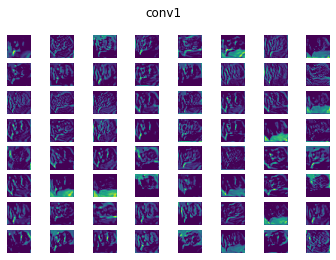

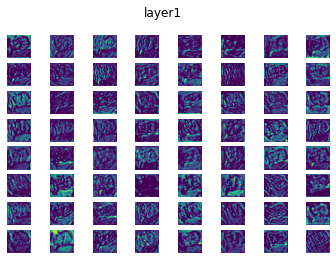

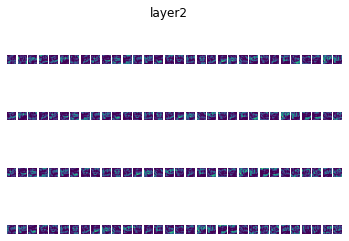

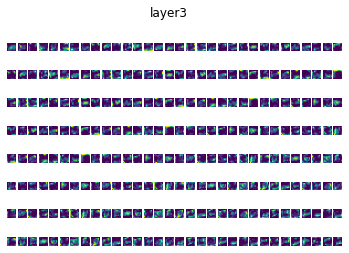

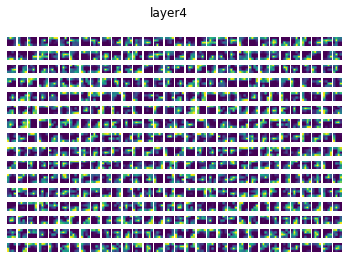

In [32]:
#!pip install matplotlib

import matplotlib.pyplot as plt

plt.tight_layout()


activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

vis_labels = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4']

for l in vis_labels:

    getattr(model, l).register_forward_hook(get_activation(l))
    
    
data, _ = cifar10_test[0]
data = data.unsqueeze_(0).to(device = device, dtype = dtype)

output = model(data)



for idx, l in enumerate(vis_labels):

    act = activation[l].squeeze()

    if idx < 2:
        ncols = 8
    else:
        ncols = 32
        
    nrows = act.size(0) // ncols
    
    fig, axarr = plt.subplots(nrows, ncols)
    fig.suptitle(l)


    for i in range(nrows):
        for j in range(ncols):
            axarr[i, j].imshow(act[i * nrows + j].cpu())
            axarr[i, j].axis('off')